Lo scopo di questo notebook è quello di testare diversi algoritmi di Machine Learning per la predizione della variabile categorica binaria individuata come target da chi ha fornito il dataset, cioè Loan_Status. Sono inoltre stati fatti tentativi per predire la variabile numerica continua Credit_Score, perché si è rivelata la variabile più importante nel predire Loan_Status.

L'idea di base è stata quella di produrre delle Pipeline per la preparazione del dataset in modi diversi ed il successivo training dei modelli, cercando i migliori Iper-Parametri degli algoritmi mediante Grid-Search. Costruire delle Pipeline permette eventualmente di salvare quelle che portano ai risultati migliori per poi essere riusate.

- Tutte le Grid-Search usate si basano sulla 3-Fold Cross-Validation: per ogni combinazione di parametri vengono eseguite 3 iterazioni, nelle quali, a turno, 2/3 del dataset vengono usati per istruire il modello (Training Set) e 1/3 viene usato per testarlo (Validation Set). Per ciascuna iterazione viene calcolata la metrica AUC (Area Under Curve, ie. the ROC) e dopo le 3 iterazioni si ottiene la AUC media. Così si fa per ogni combinazione di parametri e alla fine si sceglie come combinazione migliore quella che ha portato alla AUC media più alta. Il modello con la combinazione migliore di parametri infine viene fittato nuovamente sull'intero dataset.

Infine la Grid-Search è stata inoltre usata con il modello migliore per ottenere la Pipeline migliore contenente PCA + modello migliore, ottimizzando il numero di componenti principali della PCA. Questa procedura permette di ottenere gli stessi risultati del modello migliore a se stante ma con il vantaggio che nel caso della Pileline PCA + modello migliore quest'ultimo viene istruito su un numero inferiore di Features (il numero di features più piccolo possibile che porta alla performance massima). Questa sarà la Pipeline da salvare e riusare, insieme alla rispettiva Pipeline di Data Preparation.

In [1]:
# librerie

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.sql.types import StringType
from pyspark.sql import Row

from pyspark.ml.linalg import Vector as MLVector, Vectors as MLVectors
from pyspark.ml.feature import *

from pyspark.ml.classification import *
from pyspark.ml.regression import *

from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml import Pipeline, PipelineModel

from pyspark.ml.evaluation import *


#####################################   mllib   #####################################

from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vector as MLLibVector, Vectors as MLLibVectors

from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics

In [2]:
# sessione

sc = SparkContext(appName="DDAM_Project", master="local[*]")
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("DDAM_Project") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
sdf = spark.read.parquet("hdfs://kddrtserver11.isti.cnr.it:9000/user/hpsa04/bank_loan_status_dataset")

# generiamo un training e un test set che verranno usati in tutto il notebook (per classificazione e regressione)
training, test = sdf.randomSplit([0.7, 0.3])


# test composition of the output class respects the original composition of the class in the whole dataset

perc_Loan_Status = test.groupby('Loan_Status').count().collect()
perc_Charged_Off = 100 * perc_Loan_Status[1]['count']/(perc_Loan_Status[0]['count'] + perc_Loan_Status[1]['count'])
perc_Fully_Paid = 100 * perc_Loan_Status[0]['count']/(perc_Loan_Status[0]['count'] + perc_Loan_Status[1]['count'])

print('test set "Charged_Off" percentage over total:', perc_Charged_Off)
print('test set "Fully_Paid" percentage over total:', perc_Fully_Paid)

test set "Charged_Off" percentage over total: 30.41755839898001
test set "Fully_Paid" percentage over total: 69.58244160102


In [4]:
def get_ml_data_preparation_stages(spark_df, model_type, target_col, columns_toExclude=[], encode_categoricals=True, scale=False):
    """funzione che restituisce una lista degli stages che devono essere applicati al dataset (tramite una Pipeline)
    per prepararlo prima di potervi istruire qualsiasi algoritmo di Machine Learning (Classification e Regression)"""
    
    columns_categorical = [col.name for col in spark_df.schema.fields if isinstance(col.dataType, StringType)]
    
    columns_toExclude += [target_col]
    
    (encoded_columns, stages) = ([], [])
    
    if encode_categoricals:
        columns_toEncode = [col for col in columns_categorical if col not in columns_toExclude]
        
        for col in columns_toEncode:
            encoder = StringIndexer(inputCol = col, outputCol = col + "_encoded", stringOrderType = 'alphabetDesc')
            stages += [encoder]
            encoded_columns += [encoder.getOutputCol()]
    
    features = [col for col in spark_df.columns if\
                (col not in columns_toExclude and col not in columns_categorical)] + encoded_columns
    
    assembler = VectorAssembler(inputCols = features, outputCol = "features")
    stages += [assembler]
    
    if scale:
        scaler = StandardScaler(inputCol = "features", outputCol = "scaled_features", withStd=True, withMean=False)
        stages += [scaler]
    
    if model_type == 'classification':
        label_encoder = StringIndexer(inputCol = target_col, outputCol = "label")
        stages += [label_encoder]
    
    return stages

# Classification on "Loan_Status"

## - Numerical features Classifiers

- Data Preparation Steps

In [5]:
DP_stages = get_ml_data_preparation_stages(spark_df = sdf, model_type = 'classification', target_col = 'Loan_Status',
                                           columns_toExclude = [], encode_categoricals = False, scale = True)
DP_stages

[VectorAssembler_0a44f410755a,
 StandardScaler_08de9cc6ead4,
 StringIndexer_42c66380789a]

In [6]:
DP_pipeline = Pipeline(stages = DP_stages).fit(sdf)

training_prepared = DP_pipeline.transform(training)
test_prepared = DP_pipeline.transform(test)

print('training:')
print(training.rdd.first())
print('\ntraining_prepared:')
print(training_prepared.rdd.first())
print('\ntest:')
print(test.rdd.first())
print('\ntest_prepared:')
print(test_prepared.rdd.first())

training:
Row(Annual_Income=1930, Bankruptcies=0, Credit_Score=718, Current_Credit_Balance=621, Current_Loan_Amount=319, Debt_Income_Rate=13.496, Home_Ownership='Rent', Installment_Rate=6.8044, Loan_Status='Fully Paid', Maximum_Open_Credit=830, Monthly_Debt=21.7061, Months_since_last_delinquent='Never committed', Number_of_Credit_Problems=0, Number_of_Open_Accounts=3, Purpose='Buy a Car', Tax_Liens=0, Term='Short Term', Years_in_current_job=2.0, Years_of_Credit_History=29.0, cluster_label=1)

training_prepared:
Row(Annual_Income=1930, Bankruptcies=0, Credit_Score=718, Current_Credit_Balance=621, Current_Loan_Amount=319, Debt_Income_Rate=13.496, Home_Ownership='Rent', Installment_Rate=6.8044, Loan_Status='Fully Paid', Maximum_Open_Credit=830, Monthly_Debt=21.7061, Months_since_last_delinquent='Never committed', Number_of_Credit_Problems=0, Number_of_Open_Accounts=3, Purpose='Buy a Car', Tax_Liens=0, Term='Short Term', Years_in_current_job=2.0, Years_of_Credit_History=29.0, cluster_label

###  Logistic Regression

In [7]:
logr = LogisticRegression(featuresCol="scaled_features")

paramGrid = ParamGridBuilder()\
    .addGrid(logr.elasticNetParam, [0.0, 1])\
    .addGrid(logr.regParam, [0.1, 0.01])\
    .build()

crossval = CrossValidator(estimator=logr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),  # "areaUnderROC" (default)
                          numFolds=3,
                          parallelism=10)  # il parametro parallelism permette di parallelizzare la Cross Validation

cvModel = crossval.fit(training_prepared)

cvModel.bestModel.extractParamMap()

{Param(parent='LogisticRegression_06473bade60a', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_06473bade60a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LogisticRegression_06473bade60a', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_06473bade60a', name='featuresCol', doc='features column name'): 'scaled_features',
 Param(parent='LogisticRegression_06473bade60a', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_06473bade60a', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_06473bade60a', name='maxIter', doc='maximum number of iterations (>=

Since only one metric can be chosen in the BinaryClassificationEvaluator (ie Area under the ROC Curve), we use the MulticlassClassificationEvaluator, that we found out can be used as well.

https://spark.apache.org/docs/latest/api/java/index.html?org/apache/spark/ml/evaluation/MulticlassClassificationEvaluator.html

In [8]:
prediction = cvModel.transform(test_prepared)

accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(prediction)
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(prediction)
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(prediction)
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(prediction)

print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % (accuracy))
print("Precision = %g" % (precision))
print("Recall = %g" % (recall))
print("F1 = %g" % (f1))

Test Error = 0.302172
Accuracy = 0.697828
Precision = 0.654142
Recall = 0.697828
F1 = 0.592192


###  Support Vector Machines

il SVM Classifier è troppo lento e quindi è meglio non ottimizzare nessun parametro con la Grid Search.

In [9]:
lsvc = LinearSVC(featuresCol="scaled_features", maxIter=40)
model = lsvc.fit(training_prepared)

In [10]:
prediction = model.transform(test_prepared)

accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(prediction)
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(prediction)
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(prediction)
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(prediction)

print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % (accuracy))
print("Precision = %g" % (precision))
print("Recall = %g" % (recall))
print("F1 = %g" % (f1))

Test Error = 0.304176
Accuracy = 0.695824
Precision = 0.484172
Recall = 0.695824
F1 = 0.571016


## - Categorical and Numerical features Classifiers

- Data Preparation Steps

In [11]:
DP_stages = get_ml_data_preparation_stages(spark_df = sdf, model_type = 'classification', target_col = 'Loan_Status',
                                           columns_toExclude = [], encode_categoricals = True, scale = False)

inputCols = DP_stages[-2].getInputCols()

DP_stages

[StringIndexer_42df89b0cd6a,
 StringIndexer_a37b5345c030,
 StringIndexer_755f4ad2d574,
 StringIndexer_ebf2dc6b0817,
 VectorAssembler_ecc2f85a8230,
 StringIndexer_86d5d6d1e207]

In [12]:
DP_pipeline = Pipeline(stages = DP_stages).fit(sdf)

# DP_pipeline.save('DP_pipeline')
# DP_pipeline = PipelineModel.load('DP_pipeline')

labels = DP_pipeline.stages[-1].labels

training_prepared = DP_pipeline.transform(training)
test_prepared = DP_pipeline.transform(test)

print('training:')
print(training.rdd.first())
print('\ntraining_prepared:')
print(training_prepared.rdd.first())
print('\ntest:')
print(test.rdd.first())
print('\ntest_prepared:')
print(test_prepared.rdd.first())

training:
Row(Annual_Income=1930, Bankruptcies=0, Credit_Score=718, Current_Credit_Balance=621, Current_Loan_Amount=319, Debt_Income_Rate=13.496, Home_Ownership='Rent', Installment_Rate=6.8044, Loan_Status='Fully Paid', Maximum_Open_Credit=830, Monthly_Debt=21.7061, Months_since_last_delinquent='Never committed', Number_of_Credit_Problems=0, Number_of_Open_Accounts=3, Purpose='Buy a Car', Tax_Liens=0, Term='Short Term', Years_in_current_job=2.0, Years_of_Credit_History=29.0, cluster_label=1)

training_prepared:
Row(Annual_Income=1930, Bankruptcies=0, Credit_Score=718, Current_Credit_Balance=621, Current_Loan_Amount=319, Debt_Income_Rate=13.496, Home_Ownership='Rent', Installment_Rate=6.8044, Loan_Status='Fully Paid', Maximum_Open_Credit=830, Monthly_Debt=21.7061, Months_since_last_delinquent='Never committed', Number_of_Credit_Problems=0, Number_of_Open_Accounts=3, Purpose='Buy a Car', Tax_Liens=0, Term='Short Term', Years_in_current_job=2.0, Years_of_Credit_History=29.0, cluster_label

###  Naive Bayes Classifier

In [13]:
nb = NaiveBayes(featuresCol="features", modelType='multinomial')

paramGrid = ParamGridBuilder()\
    .addGrid(nb.smoothing,[0.4, 0.7, 1, 1.3, 1.6])\
    .build()

crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          parallelism=10) 

cvModel = crossval.fit(training_prepared)

cvModel.bestModel.extractParamMap()

{Param(parent='NaiveBayes_dbee8ae89448', name='featuresCol', doc='features column name'): 'features',
 Param(parent='NaiveBayes_dbee8ae89448', name='labelCol', doc='label column name'): 'label',
 Param(parent='NaiveBayes_dbee8ae89448', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default) and bernoulli.'): 'multinomial',
 Param(parent='NaiveBayes_dbee8ae89448', name='predictionCol', doc='prediction column name'): 'prediction',
 Param(parent='NaiveBayes_dbee8ae89448', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities'): 'probability',
 Param(parent='NaiveBayes_dbee8ae89448', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction',
 Param(parent='NaiveBayes_dbee8ae89448', name='smoothing', doc='The smoothing

In [14]:
prediction = cvModel.transform(test_prepared)

accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(prediction)
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(prediction)
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(prediction)
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(prediction)

print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % (accuracy))
print("Precision = %g" % (precision))
print("Recall = %g" % (recall))
print("F1 = %g" % (f1))

Test Error = 0.564273
Accuracy = 0.435727
Precision = 0.616949
Recall = 0.435727
F1 = 0.426904


### Decision Tree

In [15]:
dt = DecisionTreeClassifier(featuresCol="features")

paramGrid = ParamGridBuilder()\
        .addGrid(dt.maxDepth, [2, 10, 19] )\   # la max depth deve essere al massimo pari al numero di features (l'ha detto il prof ma a me non torna tanto, ragionaci)
        .addGrid(dt.impurity, ['entropy', 'gini'])\
        .build()

crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          parallelism=10)  

cvModel = crossval.fit(training_prepared)

cvModel.bestModel.extractParamMap()

{Param(parent='DecisionTreeClassifier_1452ce5b3b97', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='DecisionTreeClassifier_1452ce5b3b97', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='DecisionTreeClassifier_1452ce5b3b97', name='featuresCol', doc='features column name'): 'features',
 Param(parent='DecisionTreeClassifier_1452ce5b3b97', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'entropy',
 Param(parent='DecisionTreeClassifier_1452ce5b3b97', name='labelCol', doc='label column name'): '

In [16]:
prediction = cvModel.transform(test_prepared)

accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(prediction)
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(prediction)
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(prediction)
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(prediction)

print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % (accuracy))
print("Precision = %g" % (precision))
print("Recall = %g" % (recall))
print("F1 = %g" % (f1))

Test Error = 0.39939
Accuracy = 0.60061
Precision = 0.603509
Recall = 0.60061
F1 = 0.602026


### Random Forest

the Random Forest Classifiers turned out to be the best classification model, so we spend a bit more analysis on it.

In [17]:
rfc = RandomForestClassifier(featuresCol="features")

paramGrid = ParamGridBuilder()\
    .addGrid(rfc.numTrees, [10, 20, 30])\
    .addGrid(rfc.maxDepth, [2, 10, 19])\
    .build()

crossval = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          parallelism=10)

cvModel = crossval.fit(training_prepared)

cvModel.bestModel.extractParamMap()

{Param(parent='RandomForestClassifier_f6b7a348b19e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_f6b7a348b19e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_f6b7a348b19e', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_f6b7a348b19e', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_f6b7a348b19e', 

In [18]:
# the composition of all trees of this Ensamble method
print(cvModel.bestModel.toDebugString)

RandomForestClassificationModel (uid=RandomForestClassifier_f6b7a348b19e) with 30 trees
  Tree 0 (weight 1.0):
    If (feature 4 <= 3274.5)
     If (feature 2 <= 738.5)
      If (feature 15 in {1.0,2.0,3.0})
       If (feature 0 <= 16247.5)
        If (feature 10 <= 7.5)
         If (feature 9 <= 1.5)
          If (feature 14 <= 0.5)
           If (feature 10 <= 3.5)
            If (feature 5 <= 10.79985)
             If (feature 3 <= 670.5)
              Predict: 1.0
             Else (feature 3 > 670.5)
              Predict: 0.0
            Else (feature 5 > 10.79985)
             Predict: 1.0
           Else (feature 10 > 3.5)
            If (feature 5 <= 4.27)
             Predict: 1.0
            Else (feature 5 > 4.27)
             If (feature 2 <= 728.5)
              Predict: 0.0
             Else (feature 2 > 728.5)
              Predict: 1.0
          Else (feature 14 > 0.5)
           If (feature 6 <= 4.681900000000001)
            If (feature 6 <= 4.17765)
             Pre

the feature's importance deriving from the trained model shows that 'Credit_Score' and 'Term_encoded' are the most important attributes for predicting 'Loan_Status'.

[('Credit_Score', 0.14842357937300926), ('Term_encoded', 0.14481704574484602), ('Annual_Income', 0.10083048802579911), ('Debt_Income_Rate', 0.0913644489750382), ('Maximum_Open_Credit', 0.06641827080115466), ('Current_Loan_Amount', 0.05607844633764221), ('Years_of_Credit_History', 0.0548727105492038), ('Current_Credit_Balance', 0.051275667399699264), ('Number_of_Open_Accounts', 0.0500246904429766), ('Installment_Rate', 0.04984852413502397), ('Monthly_Debt', 0.04710576862309912), ('Years_in_current_job', 0.041892753620475745), ('Home_Ownership_encoded', 0.028562494695270776), ('Purpose_encoded', 0.024395605012045067), ('Months_since_last_delinquent_encoded', 0.01749945085086561), ('Number_of_Credit_Problems', 0.009321952801329848), ('Bankruptcies', 0.007149946423902226), ('Tax_Liens', 0.0050831198096146345), ('cluster_label', 0.005035036379003885)]


<AxesSubplot:ylabel='feature'>

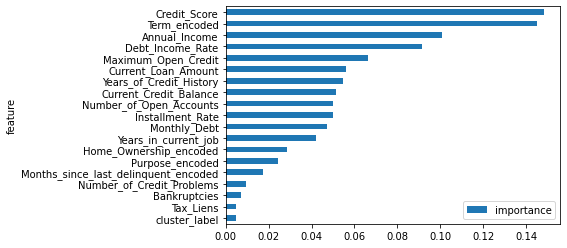

In [19]:
features_importance = list(zip(inputCols, cvModel.bestModel.featureImportances))

features_importance.sort(key = lambda x: x[1], reverse = True)
print(features_importance)

features_importance.sort(key = lambda x: x[1], reverse = False)
pd.DataFrame(features_importance, columns=['feature','importance']).set_index('feature').plot(kind='barh')

In [20]:
prediction = cvModel.transform(test_prepared)

prediction = IndexToString(inputCol="prediction", outputCol="Loan_Status_prediction", labels=labels).transform(prediction)

accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(prediction)
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(prediction)
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(prediction)
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(prediction)

print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % (accuracy))
print("Precision = %g" % (precision))
print("Recall = %g" % (recall))
print("F1 = %g" % (f1))

Test Error = 0.299121
Accuracy = 0.700879
Precision = 0.665765
Recall = 0.700879
F1 = 0.605323


In [21]:
prediction.groupBy('Loan_Status_prediction').count().show()

+----------------------+-----+
|Loan_Status_prediction|count|
+----------------------+-----+
|            Fully Paid|21226|
|           Charged Off|  735|
+----------------------+-----+



In [22]:
prediction.filter(prediction['Loan_Status'] == 'Charged Off')\
.filter(prediction['Loan_Status_prediction'] == 'Charged Off').count()

423

In [23]:
prediction.filter(prediction['Loan_Status_prediction'] == 'Charged Off').select('Loan_Status', 'Loan_Status_prediction', 'probability').show()

+-----------+----------------------+--------------------+
|Loan_Status|Loan_Status_prediction|         probability|
+-----------+----------------------+--------------------+
|Charged Off|           Charged Off|[0.48107042014193...|
|Charged Off|           Charged Off|[0.39117597844993...|
|Charged Off|           Charged Off|[0.34376217439298...|
|Charged Off|           Charged Off|[0.48380651317984...|
| Fully Paid|           Charged Off|[0.43960232341856...|
|Charged Off|           Charged Off|[0.48028296249938...|
| Fully Paid|           Charged Off|[0.46826770858034...|
| Fully Paid|           Charged Off|[0.45877068019882...|
| Fully Paid|           Charged Off|[0.46146680855241...|
| Fully Paid|           Charged Off|[0.47868157762700...|
| Fully Paid|           Charged Off|[0.45343612594624...|
|Charged Off|           Charged Off|[0.45395522222784...|
|Charged Off|           Charged Off|[0.49971491245173...|
| Fully Paid|           Charged Off|[0.49478740315583...|
| Fully Paid| 

- Fittiamo nuovamente la Random Forest, con i migliori parametri ottenuti, sul dataset con dimensioni ridotte tramite la PCA, ottimizzando per il parametro k, cioè il numero di componenti principali. In questo modo si otterrà il miglior modello possibile istruendolo sul numero minore possibile di features. Questo modello potrà poi essere salvato e riusato per effettuare predizioni.

In [24]:
features_len = len(training_prepared.rdd.first()['features'])
features_len   # numero di features originali su cui il modello verrebbe istruito senza PCA.

19

In [25]:
pca = PCA(inputCol="features", outputCol="pca_features")
best_rfc = RandomForestClassifier(featuresCol="pca_features", numTrees=30, maxDepth=10)

classification_stages = [pca, best_rfc]

paramGrid = ParamGridBuilder()\
    .addGrid(pca.k, [2, 3, 4, features_len - 5, features_len - 4, features_len - 3, features_len - 2, features_len - 1])\
    .build()

crossval = CrossValidator(estimator=Pipeline(stages = classification_stages),
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3,
                          parallelism=10)

cvModel = crossval.fit(training_prepared)

# cvModel.save('Best_Classification_Model')
# cvModel = PipelineModel.load('Best_Classification_Model')

print('Best Pipeline:')
print(cvModel.bestModel.stages)
print('\nBest PCA Parameters:')
print(cvModel.bestModel.stages[0].extractParamMap())

Best Pipeline:
[PCA_2b345fcc7064, RandomForestClassificationModel (uid=RandomForestClassifier_597c35321eb0) with 30 trees]

Best PCA Parameters:
{Param(parent='PCA_2b345fcc7064', name='outputCol', doc='output column name'): 'pca_features', Param(parent='PCA_2b345fcc7064', name='inputCol', doc='input column name'): 'features', Param(parent='PCA_2b345fcc7064', name='k', doc='the number of principal components (> 0)'): 16}


bastano le prime 16 componenti principali per ottenere la stessa performance che si ha su 19 features

In [26]:
prediction = cvModel.transform(test_prepared)

accuracy = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy").evaluate(prediction)
precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(prediction)
recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(prediction)
f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(prediction)

print("Test Error = %g" % (1.0 - accuracy))
print("Accuracy = %g" % (accuracy))
print("Precision = %g" % (precision))
print("Recall = %g" % (recall))
print("F1 = %g" % (f1))

Test Error = 0.299622
Accuracy = 0.700378
Precision = 0.664357
Recall = 0.700378
F1 = 0.603169


--------------------

# Classification with MLLib Logistic Regression and PCA:

iterating over k, fitting the logistic regression model, and measuring the results.

Here is where each set of k principal components is plugged into the Logistic Regression model to see how well the metrics come out relative to the unreduced dataset. Even though the results are impressive (we could cut the number of dimensions by half, namely from 14 down to 7, and lose only a bit over 1% in accuracy), the idea here was to demonstratte the use of PCA in the Apache Spark paradigm rather than actually reducing the dataset.

- here we do again the Data Preparation steps

In [5]:
columns = sdf.schema.names

columns_categorical = [col.name for col in sdf.schema.fields if isinstance(col.dataType, StringType)]

columns_numerical = [col for col in columns if col not in columns_categorical]

numd=columns_numerical+ ['Loan_Status'] #numerical columns+dependent variable (Loan Status)

datas=sdf[numd] #spark numerical + loan status

datas = datas.withColumnRenamed("Loan_Status","label")

#vectorizing the numerical columns
assembler = VectorAssembler(
    inputCols=columns_numerical,
    outputCol="features")
output = assembler.transform(datas)

#normalization
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='std_features')
model = standardizer.fit(output)
output = model.transform(output)

indexer = StringIndexer(inputCol="label", outputCol="label_idx")
indexed = indexer.fit(output).transform(output)

sonar = indexed.select(['std_features', 'label', 'label_idx']) #extract only features of interest

In [6]:
for k in range (1,(len(columns_numerical))):
    pca = PCA(k=k, inputCol="std_features", outputCol="pca")
    model = pca.fit(sonar)
    transformed = model.transform(sonar)

    #data=transformed.select('pca', 'label_idx')

    data = transformed.rdd.map(lambda x: LabeledPoint(x[2], MLLibVectors.fromML(x[3]))) 

    train_mllib, test_mllib = data.randomSplit([0.7, 0.3])

    # Run training algorithm to build the model
    model = LogisticRegressionWithLBFGS.train(train_mllib, numClasses=2)

    # Compute raw scores on the test set
    predictionAndLabels = test_mllib.map(lambda lp: (float(model.predict(lp.features)), lp.label))

    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    binary= BinaryClassificationMetrics(predictionAndLabels)
    # Overall statistics
    print('k number of components=',k)
    
    accuracy=metrics.accuracy 
    cm=metrics.confusionMatrix()
    aupr=binary.areaUnderPR
    auc=binary.areaUnderROC
    print("Summary Stats")
    print("Area under precision recall curve = %s" % aupr)
    print("Area under roc curve = %s" % auc)
    print('Accuracy = ', accuracy)
    
    #precision, recall and f1 are all depracated since 2.2.2. version of Spark Apache. Only accuracy is available. 
    print(cm)

    # Statistics by class
    labels = data.map(lambda lp: lp.label).distinct().collect()
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    print('\n')

k number of components= 1
Summary Stats
Area under precision recall curve = 0.32636149507841905
Area under roc curve = 0.5240542066780776
Accuracy =  0.5417319929908697
DenseMatrix([[8544., 6435.],
             [3503., 3204.]])
Class 0.0 precision = 0.7092222129990869
Class 0.0 recall = 0.5703985579811737
Class 0.0 F1 Measure = 0.6322800266410125
Class 1.0 precision = 0.33239962651727356
Class 1.0 recall = 0.47770985537498134
Class 1.0 F1 Measure = 0.3920225131530649
Weighted recall = 0.5417319929908697
Weighted precision = 0.5926793241522031
Weighted F(1) Score = 0.5579736933862092
Weighted F(0.5) Score = 0.5766002717826845
Weighted false positive rate = 0.4936235796347147


k number of components= 2
Summary Stats
Area under precision recall curve = 0.3113051558828591
Area under roc curve = 0.5154125789926227
Accuracy =  0.5357290186551772
DenseMatrix([[8642., 6617.],
             [3512., 3046.]])
Class 0.0 precision = 0.7110416323844002
Class 0.0 recall = 0.5663542827183957
Class 0.0

k number of components= 13
Summary Stats
Area under precision recall curve = 0.3662296447222287
Area under roc curve = 0.581632043986527
Accuracy =  0.5850842761486954
DenseMatrix([[8865., 6146.],
             [2839., 3805.]])
Class 0.0 precision = 0.7574333561175667
Class 0.0 recall = 0.5905669175937646
Class 0.0 F1 Measure = 0.6636720943290286
Class 1.0 precision = 0.3823736307908753
Class 1.0 recall = 0.5726971703792896
Class 1.0 F1 Measure = 0.4585718589936728
Weighted recall = 0.5850842761486954
Weighted precision = 0.6423607717227138
Weighted F(1) Score = 0.600745012197045
Weighted F(0.5) Score = 0.6226299230648924
Weighted false positive rate = 0.4218201881756413


k number of components= 14
Summary Stats
Area under precision recall curve = 0.36998097396117646
Area under roc curve = 0.5843794678718537
Accuracy =  0.5888498562890643
DenseMatrix([[9041., 6128.],
             [2884., 3866.]])
Class 0.0 precision = 0.7581551362683439
Class 0.0 recall = 0.5960181950029666
Class 0.0 F

In [7]:
sonar=sonar.rdd

data = sonar.map(lambda x: LabeledPoint(x[2], MLLibVectors.fromML(x[0]))) 
#converting a ml vector to mll vectr

train_mllib, test_mllib = data.randomSplit([0.7, 0.3])

model = LogisticRegressionWithLBFGS.train(train_mllib)

y_yhat = test_mllib.map(lambda x: (x.label, model.predict(x.features)))
err = y_yhat.filter(lambda x: x[0] != x[1]).count() / float(test.count())
print("Error = " + str(err), 'Accuracy = ', 1-err )

Error = 0.42169453940681884 Accuracy =  0.5783054605931812


-----------------

# Regression on "Credit_Score"

Escludiamo i seguenti attributi per performare la regressione su Credit Score perché sono quelli riferiti al tipo di prestito e non alle caratteristiche del cliente. Il Credit Score infatti deve essere inteso come un valore di "qualità" del debitore sulla base delle sue caratteristiche personali (comprese le caratteristiche dei debiti contratti fino a quel momento) e non deve dipendere quindi dal tipo di debito che esso deve contrarre in quel momento.

'Loan_Status' viene mantenuto perché il Credit Score assegnato ad un cliente può dipendere, anche fortemente, dall'esito che i suoi debiti hanno avuto nel passato.

In [5]:
columns_toExclude= ['Term', 'Purpose', 'cluster_label']

### Linear Regression

- Data Preparation Steps

In [6]:
DP_stages = get_ml_data_preparation_stages(spark_df = sdf, model_type = 'regression', target_col = 'Credit_Score',
                                           columns_toExclude = columns_toExclude, encode_categoricals = False, scale = True)

DP_pipeline = Pipeline(stages = DP_stages).fit(sdf)

training_prepared = DP_pipeline.transform(training)
training_prepared = training_prepared.withColumnRenamed('Credit_Score', 'label')
test_prepared = DP_pipeline.transform(test)

DP_stages

[VectorAssembler_6df27b081495, StandardScaler_eb682eb908b7]

- Model

In [7]:
linr = LinearRegression(featuresCol="scaled_features")

paramGrid = ParamGridBuilder()\
        .addGrid(linr.loss, ['squaredError', 'huber'])\
        .addGrid(linr.regParam, [0, 0.5, 1])\
        .build()

crossval = CrossValidator(estimator = linr,
                          estimatorParamMaps = paramGrid,
                          evaluator = RegressionEvaluator(),
                          numFolds = 3,
                          parallelism = 10)

cvModel = crossval.fit(training_prepared)

cvModel.bestModel.extractParamMap()

{Param(parent='LinearRegression_2310771aa033', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LinearRegression_2310771aa033', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0,
 Param(parent='LinearRegression_2310771aa033', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0.'): 1.35,
 Param(parent='LinearRegression_2310771aa033', name='featuresCol', doc='features column name'): 'scaled_features',
 Param(parent='LinearRegression_2310771aa033', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LinearRegression_2310771aa033', name='labelCol', doc='label column name'): 'label',
 Param(parent='LinearRegression_2310771aa033', name='loss', doc='The loss function to be optimized. Supported options: squaredError, huber. (Default squaredError)'): 'huber',
 Param(pa

In [8]:
print('Intercetta della Regressione Lienare:')
print(cvModel.bestModel.intercept)
print('\nCoefficienti della Regressione Lienare:')
print(cvModel.bestModel.coefficients)

Intercetta della Regressione Lienare:
723.8071479927183

Coefficienti della Regressione Lienare:
[0.03950775282883212,-0.08019337553250455,0.011824386410836558,-0.28402105582037207,-0.1891118356183296,0.05484323767380932,0.019552563159111854,-0.09786426060186652,-0.11075104087315335,-0.01725209602742957,-0.040477613371766474,-0.018210995755949314,0.1853691233459046]


In [9]:
prediction = cvModel.transform(test_prepared)

r2 = RegressionEvaluator(labelCol="Credit_Score", predictionCol="prediction", metricName="r2").evaluate(prediction)
mse = RegressionEvaluator(labelCol="Credit_Score", predictionCol="prediction", metricName="mse").evaluate(prediction)
rmse = RegressionEvaluator(labelCol="Credit_Score", predictionCol="prediction", metricName="rmse").evaluate(prediction)
mae = RegressionEvaluator(labelCol="Credit_Score", predictionCol="prediction", metricName="mae").evaluate(prediction)

print("Determination Coefficient (R^2) on test data = %g" % r2)
print("Mean Squared Error (MSE) on test data = %g" % mse)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

Determination Coefficient (R^2) on test data = -0.0260181
Mean Squared Error (MSE) on test data = 725.176
Root Mean Squared Error (RMSE) on test data = 26.9291
Mean Absolute Error (MAE) on test data = 18.8648


### Random Forest Regressor

poiché il Random Forest Regressor è risultato essere il miglior modello di regressione facciamo un'analisi più approfondita su di esso.

- Data Preparation Steps

In [6]:
DP_stages = get_ml_data_preparation_stages(spark_df = sdf, model_type = 'regression', target_col = 'Credit_Score',
                                           columns_toExclude = columns_toExclude, encode_categoricals = True, scale = False)

inputCols = DP_stages[-1].getInputCols()

DP_pipeline = Pipeline(stages = DP_stages).fit(sdf)

training_prepared = DP_pipeline.transform(training)
training_prepared = training_prepared.withColumnRenamed('Credit_Score', 'label')
test_prepared = DP_pipeline.transform(test)

DP_stages

[StringIndexer_4217573c26dd,
 StringIndexer_6f25f97ca03d,
 StringIndexer_a3c428caa36a,
 VectorAssembler_5e7ea1ebdb55]

- Model

In [7]:
print(RandomForestRegressor().explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [9]:
rfr = RandomForestRegressor(featuresCol="features")

paramGrid = ParamGridBuilder()\
        .addGrid(rfr.numTrees, [20, 30])\
        .addGrid(rfr.maxDepth, [5, 10])\
        .build()

crossval = CrossValidator(estimator = rfr,
                          estimatorParamMaps = paramGrid,
                          evaluator = RegressionEvaluator(),
                          numFolds = 3,
                          parallelism = 10)

cvModel = crossval.fit(training_prepared)

cvModel.bestModel.extractParamMap()

{Param(parent='RandomForestRegressor_860b7e1153b1', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestRegressor_860b7e1153b1', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestRegressor_860b7e1153b1', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestRegressor_860b7e1153b1', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestRegressor_860b7e1153b1', name=

In [11]:
print('Best Random Forest Tree:')
print(cvModel.bestModel.toDebugString)

Best Random Forest Tree:
RandomForestRegressionModel (uid=RandomForestRegressor_860b7e1153b1) with 30 trees
  Tree 0 (weight 1.0):
    If (feature 4 <= 19.4999)
     If (feature 5 <= 5.67845)
      If (feature 3 <= 7672.0)
       If (feature 4 <= 11.7091)
        If (feature 14 in {1.0})
         If (feature 6 <= 5324.0)
          If (feature 7 <= 198.19305)
           If (feature 13 in {0.0,3.0})
            If (feature 0 <= 20498.0)
             If (feature 2 <= 3913.5)
              Predict: 714.9079136690648
             Else (feature 2 > 3913.5)
              Predict: 649.0
            Else (feature 0 > 20498.0)
             If (feature 15 in {1.0})
              Predict: 672.9
             Else (feature 15 not in {1.0})
              Predict: 705.4444444444445
           Else (feature 13 not in {0.0,3.0})
            If (feature 12 <= 13.350000000000001)
             If (feature 3 <= 6442.5)
              Predict: 713.3333333333334
             Else (feature 3 > 6442.5)
         

Features importances per la regressione

[('Current_Loan_Amount', 0.22248162965950677), ('Maximum_Open_Credit', 0.15155348533098265), ('Debt_Income_Rate', 0.07912508068956149), ('Years_of_Credit_History', 0.07655188438361256), ('Number_of_Open_Accounts', 0.0686420436002018), ('Annual_Income', 0.06281249825536947), ('Current_Credit_Balance', 0.06176658074779607), ('Installment_Rate', 0.05552164488099327), ('Monthly_Debt', 0.054076071739182816), ('Loan_Status_encoded', 0.04676337818832599), ('Months_since_last_delinquent_encoded', 0.041795237749246296), ('Years_in_current_job', 0.028453530100699127), ('Home_Ownership_encoded', 0.021811001696072023), ('Number_of_Credit_Problems', 0.01362655458457966), ('Bankruptcies', 0.009971206595698247), ('Tax_Liens', 0.005048171798171753)]


<AxesSubplot:ylabel='feature'>

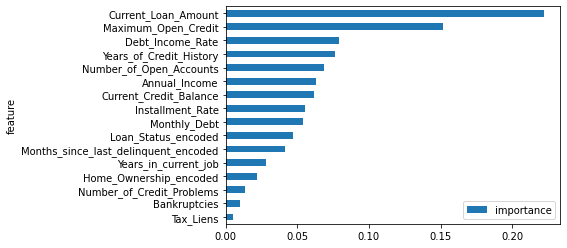

In [12]:
features_importance = list(zip(inputCols, cvModel.bestModel.featureImportances))

features_importance.sort(key = lambda x: x[1], reverse = True)
print(features_importance)

features_importance.sort(key = lambda x: x[1], reverse = False)
pd.DataFrame(features_importance, columns=['feature','importance']).set_index('feature').plot(kind='barh')

In [13]:
prediction = cvModel.transform(test_prepared)

r2 = RegressionEvaluator(labelCol="Credit_Score", predictionCol="prediction", metricName="r2").evaluate(prediction)
mse = RegressionEvaluator(labelCol="Credit_Score", predictionCol="prediction", metricName="mse").evaluate(prediction)
rmse = RegressionEvaluator(labelCol="Credit_Score", predictionCol="prediction", metricName="rmse").evaluate(prediction)
mae = RegressionEvaluator(labelCol="Credit_Score", predictionCol="prediction", metricName="mae").evaluate(prediction)

print("Determination Coefficient (R^2) on test data = %g" % r2)
print("Mean Squared Error (MSE) on test data = %g" % mse)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
print("Mean Absolute Error (MAE) on test data = %g" % mae)

Determination Coefficient (R^2) on test data = 0.15166
Mean Squared Error (MSE) on test data = 605.04
Root Mean Squared Error (RMSE) on test data = 24.5976
Mean Absolute Error (MAE) on test data = 18.2124


Nonostante si siano fittati i migliori Iper-Parametri dei modelli il Coefficiente di Determinazione Lineare (R^2) rimane sempre troppo basso.

il suo valore è maggiore di 0 e questo significa che tale modello riesce a predire i valori di 'Credit_Score' in modo migliore di quanto farebbe la sua stessa media. Ma dobbiamo purtroppo concludere che un modello di regressione per 'Credit_Score' non possa essere ricavato dal dataset fornito.

---------------------------------------------